In [25]:
import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
import flax.linen as nn
import optax
from typing import Sequence, Callable, Optional, Dict, Any, Union
import numpy as np

from mmnn_equinox import SinTUActivation#,Train_Equinox_Model


import matplotlib.pyplot as plt
plt.style.use('figures/images_style.mplstyle')



In [26]:
class MMNNLayer(eqx.Module):
    """
    MMNN Layer with fixed random weights and trainable linear output layer
    
    Args:
        d_in: Input dimension
        width: Width of the hidden layer (number of random basis functions)
        d_out: Output dimension
        activation: Activation function to apply
        use_bias: Whether to use bias in the fixed layer
        fixed_W: Fixed weight matrix (width, d_in)
        fixed_b: Fixed bias vector (width,)
        linear: Trainable linear layer (width -> d_out)
    """
    d_in: int
    width: int 
    d_out: int
    activation: Callable
    use_bias: bool
    fixed_W: jnp.ndarray
    fixed_b: jnp.ndarray
    linear: eqx.nn.Linear
    
    def __init__(self, 
                 d_in: int,
                 width: int,
                 d_out: int,
                 activation: Callable = None,
                 use_bias: bool = True,
                 seed: int = 0,
                 key: jrandom.PRNGKey = None):
        
        self.d_in = d_in
        self.width = width
        self.d_out = d_out
        self.use_bias = use_bias
        
        # Set default activation if none provided
        if activation is None:
            self.activation = SinTUActivation()
        else:
            self.activation = activation
        
        # Handle key generation
        if key is None:
            key = jrandom.PRNGKey(seed)
        
        key_w, key_b, key_linear = jrandom.split(key, 3)
        
        # Initialize fixed W matrix: maps from d_in to width
        # Using Xavier/Glorot initialization scaled by input dimension
        self.fixed_W = jrandom.normal(key_w, shape=(self.width, self.d_in)) * jnp.sqrt(2.0 / self.d_in)
        
        # Initialize fixed bias vector
        self.fixed_b = jrandom.normal(key_b, shape=(self.width,)) * jnp.sqrt(2.0 / self.d_in)
        
        # Initialize trainable linear layer: width -> d_out
        self.linear = eqx.nn.Linear(
            in_features=self.width,
            out_features=self.d_out,
            use_bias=self.use_bias,
            key=key_linear
        )
        
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """
        Forward pass through MMNN layer
        
        Args:
            x: Input tensor of shape (..., d_in)
            
        Returns:
            Output tensor of shape (..., d_out)
        """
        # Verify input dimension
        if x.shape[-1] != self.d_in:
            raise ValueError(f"Expected input dimension {self.d_in}, got {x.shape[-1]}")
        
        # Apply fixed linear transformation: x @ W.T + b
        hidden = jnp.dot(x, self.fixed_W.T) + self.fixed_b
    
        # Apply activation function
        activated = self.activation(hidden)
        
        # Apply trainable linear layer: width -> d_out
        output = self.linear(activated)
        
        return output


class MMNNModel(eqx.Module):
    """
    MMNN model with multiple layers
    
    Args:
        ranks: List of dimensions [d_in,d1,d2,...,d_out] of length n+1
        widths: List of widths for each layer [w_1,w_2,...,w_n] of length n
        activation: Activation function to apply to each layer
        use_bias: Whether to use bias in the layers
        layers: List of MMNN layers
    """
    ranks: list
    widths: list
    activation: Callable
    use_bias: bool
    layers: list
    
    def __init__(self, 
                 ranks: list,
                 widths: list,
                 activation: Callable = None,
                 use_bias: bool = True,
                 seed: int = 0,
                 key: jrandom.PRNGKey = None):
        
        self.ranks = ranks
        self.widths = widths
        self.use_bias = use_bias
        
        # Set default activation if none provided
        if activation is None:
            self.activation = SinTUActivation()
        else:
            self.activation = activation
        
        # Validate input dimensions
        if len(self.widths) + 1 != len(self.ranks):
            raise ValueError("Number of widths must be one less than number of ranks")
        
        # Handle key generation
        if key is None:
            key = jrandom.PRNGKey(seed)
        
        # Create layer configurations from ranks and widths
        layer_configs = []
        for i in range(len(self.widths)):
            d_in = self.ranks[i]
            width = self.widths[i]
            d_out = self.ranks[i+1]
            layer_configs.append((d_in, width, d_out))
        
        # Initialize layers
        self.layers = []
        keys = jrandom.split(key, len(layer_configs))
        
        for i, ((d_in, width, d_out), layer_key) in enumerate(zip(layer_configs, keys)):
            layer = MMNNLayer(
                d_in=d_in,
                width=width,
                d_out=d_out,
                activation=self.activation,
                use_bias=self.use_bias,
                key=layer_key
            )
            self.layers.append(layer)
    
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """Forward pass through all layers"""
        for layer in self.layers:
            x = layer(x)
        return x


class TrainJaxModel:
    """
    Training scheme for JAX/Equinox models
    
    Inputs:
        model: An Equinox model to train
        input_data: Input data as a jnp.ndarray
        target_data: Target data as a jnp.ndarray
        optimizer: Optimizer to use, e.g. 'adam', 'sgd'
        loss_fn: Loss function to use, e.g. 'mse', 'mae'
        learning_rate: Learning rate for the optimizer
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
        random_seed: Random seed for reproducibility
    """
    
    def __init__(self, 
                 model: eqx.Module,
                 input_data: jnp.ndarray,
                 target_data: jnp.ndarray,
                 optimizer: str = 'adam',
                 loss_fn: str = 'mse',
                 learning_rate: Union[float, optax.Schedule] = 0.001,
                 num_epochs: int = 1000,
                 batch_size: int = 32,
                 random_seed: int = 0):
        
        self.model = model
        self.loss_fn_str = loss_fn
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.random_seed = random_seed

        # Set up device
        self.device = jax.devices("gpu")[0] if jax.devices("gpu") else jax.devices("cpu")[0]
        input_data = jax.device_put(input_data, self.device)
        target_data = jax.device_put(target_data, self.device)

        self.n_samples = jnp.shape(input_data)[0]
        
        self.key = jrandom.PRNGKey(random_seed)
        self.split_train_test(input_data, target_data)
        self.n_batches = jnp.shape(self.x_train)[0] // self.batch_size
        
        # Create optimizer
        if optimizer == 'adam':
            self.optimizer = optax.adam(learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = optax.sgd(learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        # Create loss function
        self.loss_fn = self._create_loss_fn(loss_fn)
        
        # Create training step function
        self.train_step = self._create_train_step()
        
    def _create_loss_fn(self, loss_type):
        """Create loss function"""
        if loss_type == 'mse':
            def loss_fn(model, x, y):
                pred = jax.vmap(model)(x)
                return jnp.mean((pred - y) ** 2)
        elif loss_type == 'mae':
            def loss_fn(model, x, y):
                pred = jax.vmap(model)(x)
                return jnp.mean(jnp.abs(pred - y))
        else:
            raise ValueError(f"Unsupported loss function: {loss_type}")
        return loss_fn

    def split_train_test(self, input_data, target_data, test_split=0.2):
        """Split input and target data into training and validation sets"""
        n_test = int(self.n_samples * test_split)
        n_train = self.n_samples - n_test

        # Random indices for shuffling
        indices = jrandom.permutation(self.key, self.n_samples)
        train_indices = indices[:n_train]
        test_indices = indices[n_train:]

        # Split input and target data
        self.x_train = input_data[train_indices]
        self.y_train = target_data[train_indices]
        self.x_test = input_data[test_indices]
        self.y_test = target_data[test_indices]

    def batch_generator(self, x_data, y_data):
        """Generate batches of data"""
        for i in range(0, self.n_batches * self.batch_size, self.batch_size):
            x_batch = x_data[i:i + self.batch_size]
            y_batch = y_data[i:i + self.batch_size]
            yield x_batch, y_batch
        
    def _create_train_step(self):
        """Create a JIT-compiled training step function"""
        
        @eqx.filter_jit
        def train_step(model, opt_state, x_batch, y_batch):
            loss, grads = eqx.filter_value_and_grad(self.loss_fn)(model, x_batch, y_batch)
            updates, new_opt_state = self.optimizer.update(grads, opt_state, model)
            new_model = eqx.apply_updates(model, updates)
            return new_model, new_opt_state, loss
        
        return train_step
    
    def training_loop(self, print_every: int = 100):
        """Training loop"""
        import matplotlib.pyplot as plt
        
        training_losses = []
        validation_losses = []

        # Initialize optimizer state
        opt_state = self.optimizer.init(eqx.filter(self.model, eqx.is_array))
        model = self.model

        for epoch in range(self.num_epochs):
            epoch_loss = []
            self.key, subkey = jrandom.split(self.key)
            perm = jrandom.permutation(subkey, len(self.x_train))
            x_train_shuffled = self.x_train[perm]
            y_train_shuffled = self.y_train[perm]
            
            # Iterate over batches
            for x_batch, y_batch in self.batch_generator(x_train_shuffled, y_train_shuffled):
                # Perform a training step
                model, opt_state, loss = self.train_step(model, opt_state, x_batch, y_batch)
                epoch_loss.append(loss)

            # Average loss for the epoch
            avg_loss = jnp.mean(jnp.array(epoch_loss)) 
            training_losses.append(avg_loss)

            if epoch % print_every == 0 or epoch == self.num_epochs - 1:
                # Compute validation loss
                val_loss = self.loss_fn(model, self.x_test, self.y_test)
                validation_losses.append(val_loss)
                
                # Plot the model predictions
                idx_sort = jnp.argsort(self.x_test.flatten())
                x_test_sorted = self.x_test[idx_sort]
                y_test_sorted = self.y_test[idx_sort]
                predictions = jax.vmap(model)(x_test_sorted)
                
                plt.figure(figsize=(10, 5))
                plt.plot(x_test_sorted.flatten(), y_test_sorted.flatten(), 
                        label='True Function', color='blue')
                plt.plot(x_test_sorted.flatten(), predictions.flatten(), 
                        label='Model Predictions', color='red')
                plt.title(f'Epoch {epoch + 1}/{self.num_epochs} - Validation Loss: {val_loss:.4f}')
                plt.xlabel('x')
                plt.ylabel('y')
                plt.legend()
                plt.grid()
                plt.show()
                print(f"Epoch {epoch + 1}/{self.num_epochs}, "
                      f"Training Loss: {avg_loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}")
        
        return model, {'training_losses': training_losses, 'validation_losses': validation_losses}

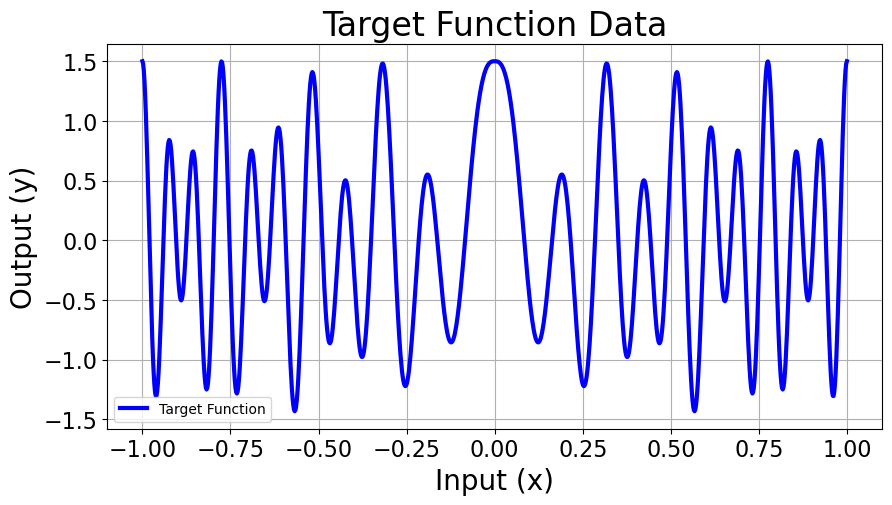

In [27]:
# Generate data
def target_function(x):
    return np.cos(20*np.pi*np.abs(x)**(1.4)) + 0.5*np.cos(12*np.pi*np.abs(x)**(1.6))

# Input data
x = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_data = target_function(x)

# Plot data
plt.figure(figsize=(10, 5))
plt.plot(x, y_data, label='Target Function', color='blue')
plt.title('Target Function Data')
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.legend()
plt.grid()
plt.show()

In [28]:


# Configuration
ranks = [1] + [18]*2 + [1]
widths = [356]*3

# Create model
key = jax.random.PRNGKey(42)

model = MMNNModel(
    ranks=ranks,
    widths=widths,
    activation=SinTUActivation(),
    use_bias=True,
    key=key
)

# Scheduler
scheduler = optax.exponential_decay(
    init_value=0.001,
    transition_steps=100,
    decay_rate=0.96,
    staircase=True
)


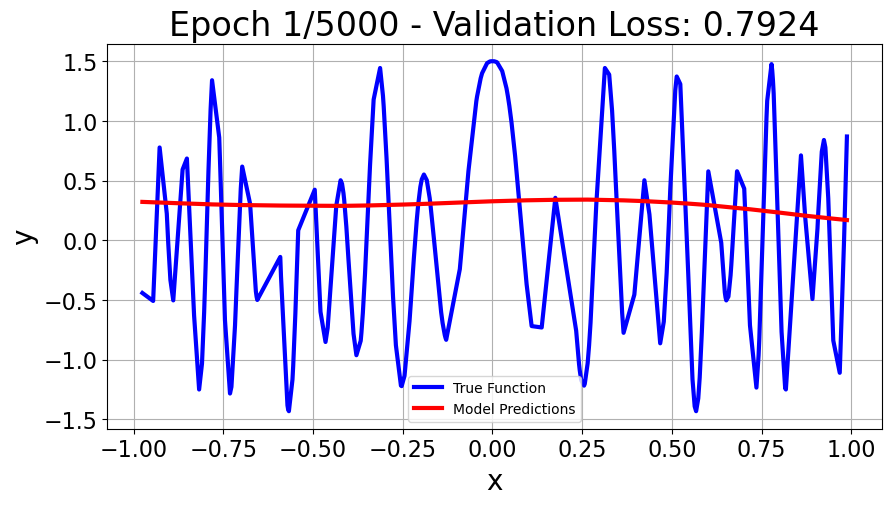

Epoch 1/5000, Training Loss: 0.8003, Validation Loss: 0.7924


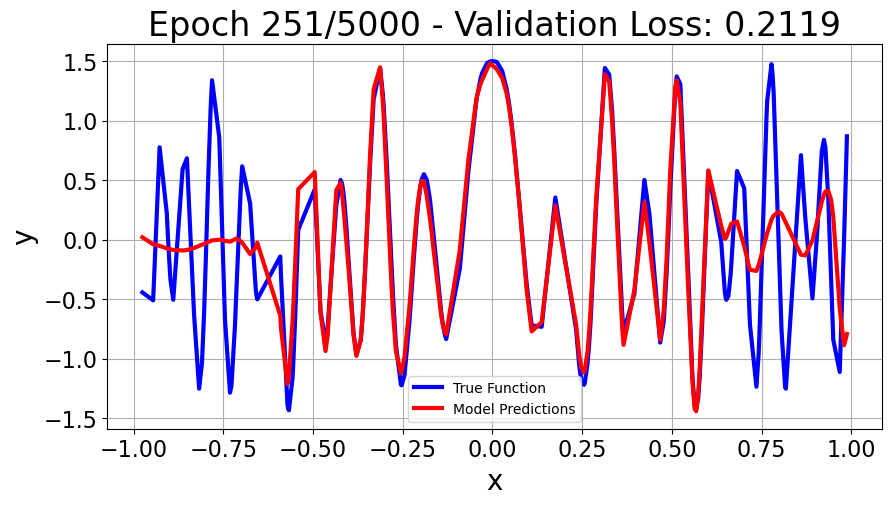

Epoch 251/5000, Training Loss: 0.2134, Validation Loss: 0.2119


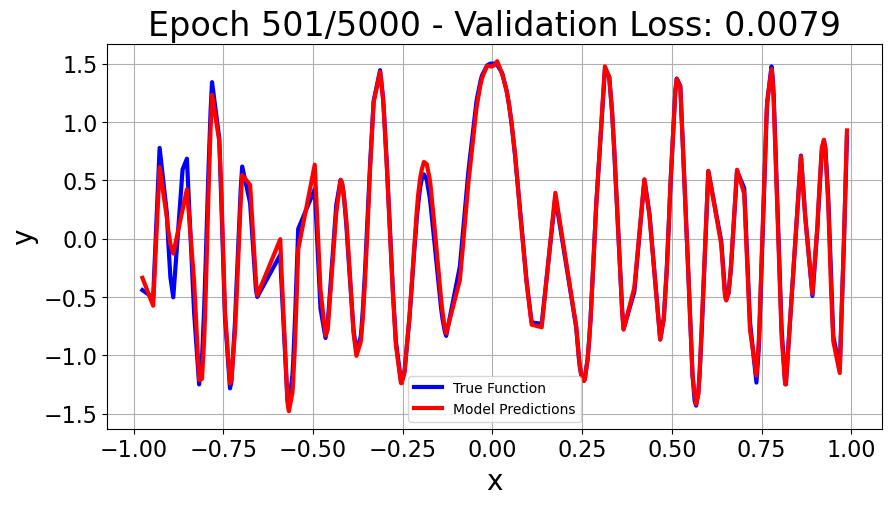

Epoch 501/5000, Training Loss: 0.0097, Validation Loss: 0.0079


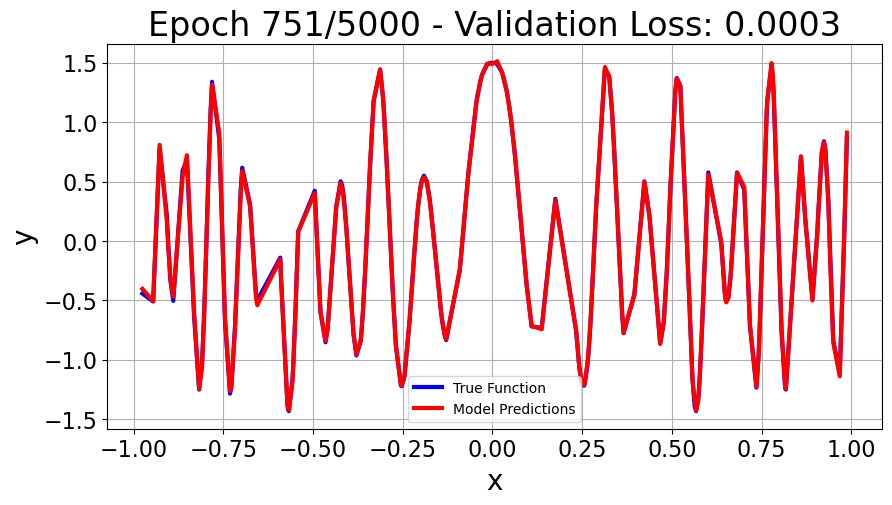

Epoch 751/5000, Training Loss: 0.0003, Validation Loss: 0.0003


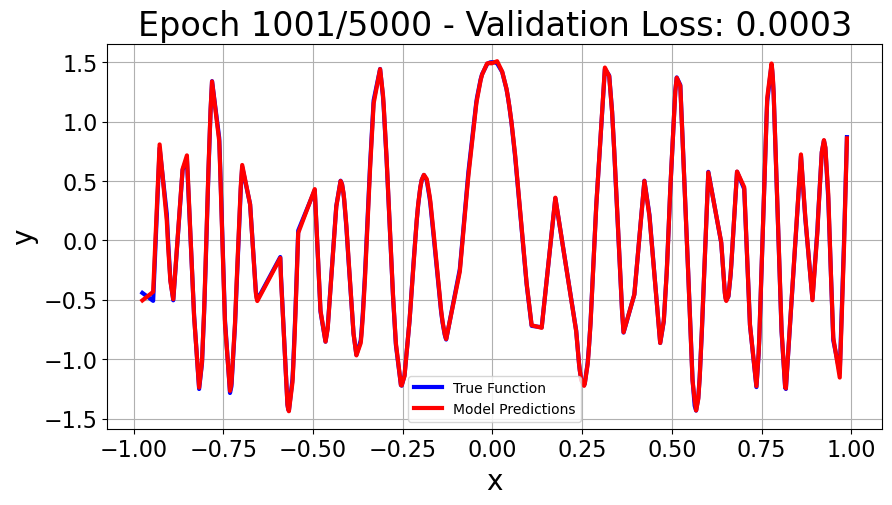

Epoch 1001/5000, Training Loss: 0.0003, Validation Loss: 0.0003


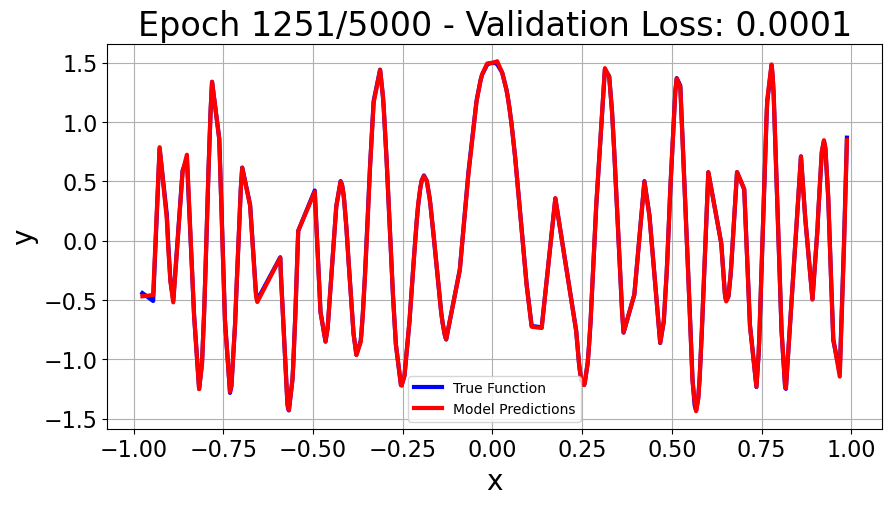

Epoch 1251/5000, Training Loss: 0.0001, Validation Loss: 0.0001


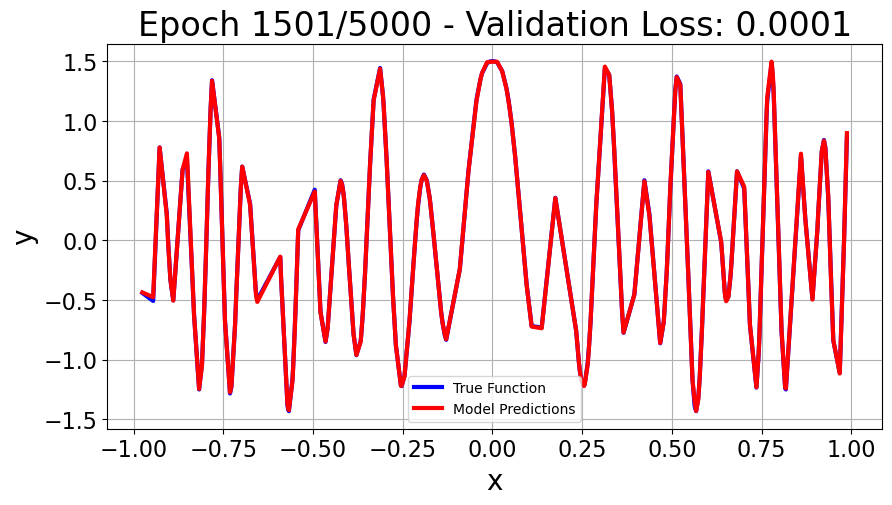

Epoch 1501/5000, Training Loss: 0.0000, Validation Loss: 0.0001


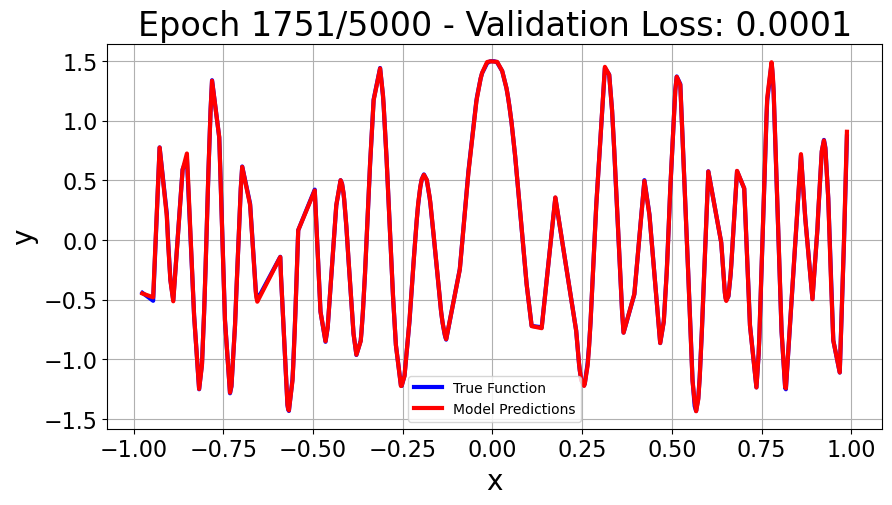

Epoch 1751/5000, Training Loss: 0.0000, Validation Loss: 0.0001


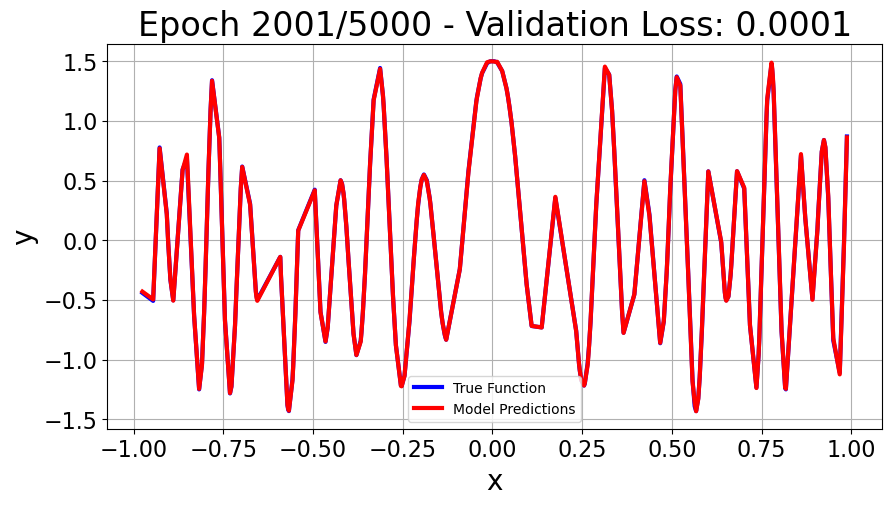

Epoch 2001/5000, Training Loss: 0.0000, Validation Loss: 0.0001


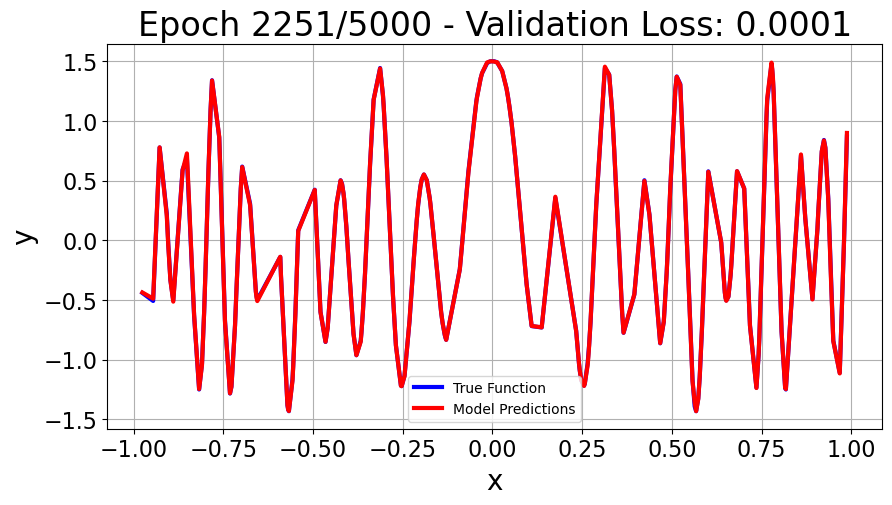

Epoch 2251/5000, Training Loss: 0.0000, Validation Loss: 0.0001


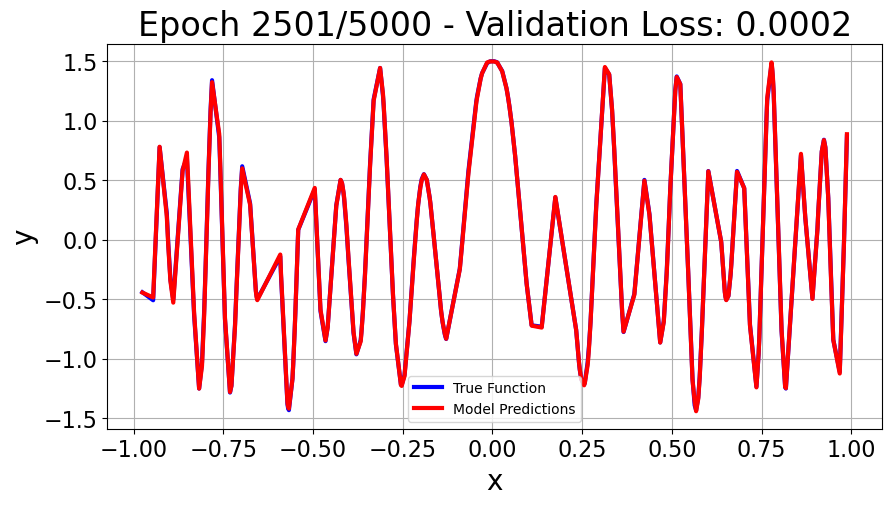

Epoch 2501/5000, Training Loss: 0.0001, Validation Loss: 0.0002


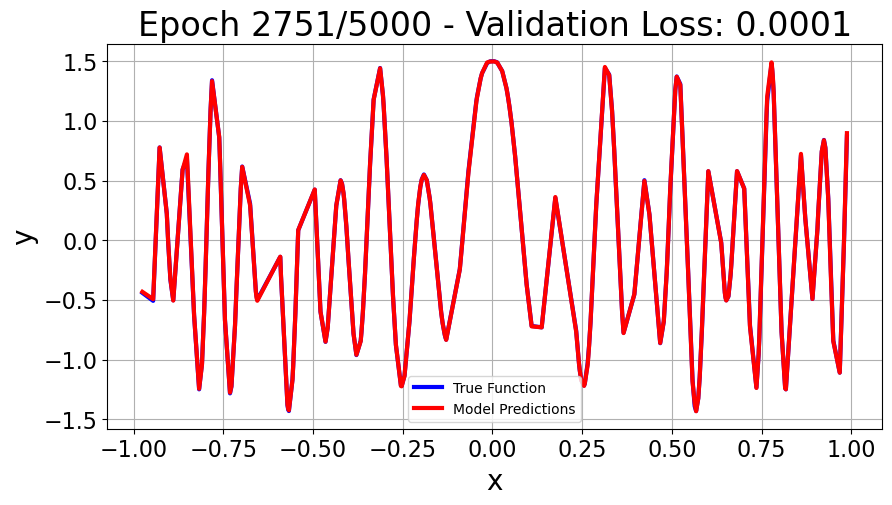

Epoch 2751/5000, Training Loss: 0.0000, Validation Loss: 0.0001


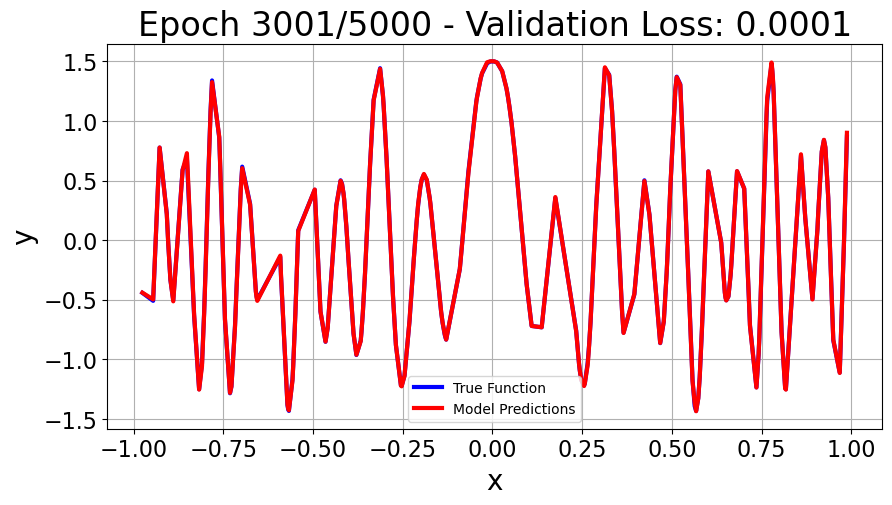

Epoch 3001/5000, Training Loss: 0.0000, Validation Loss: 0.0001


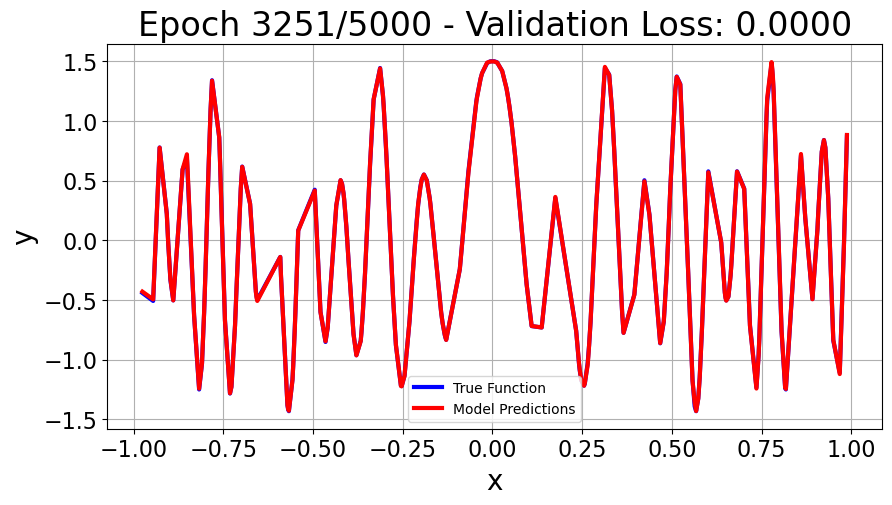

Epoch 3251/5000, Training Loss: 0.0000, Validation Loss: 0.0000


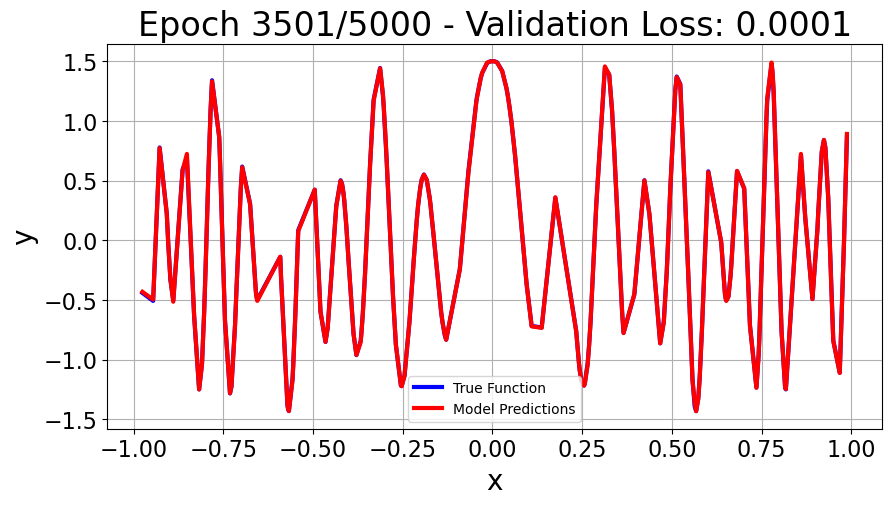

Epoch 3501/5000, Training Loss: 0.0000, Validation Loss: 0.0001


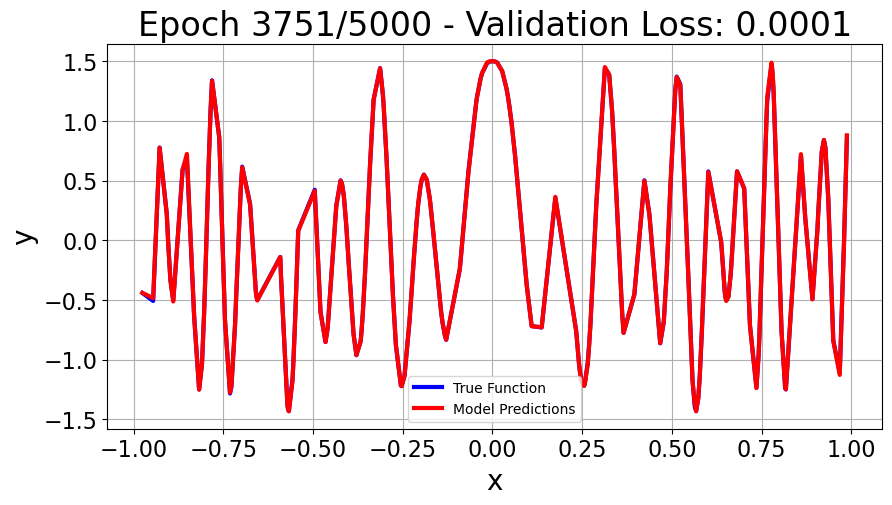

Epoch 3751/5000, Training Loss: 0.0000, Validation Loss: 0.0001


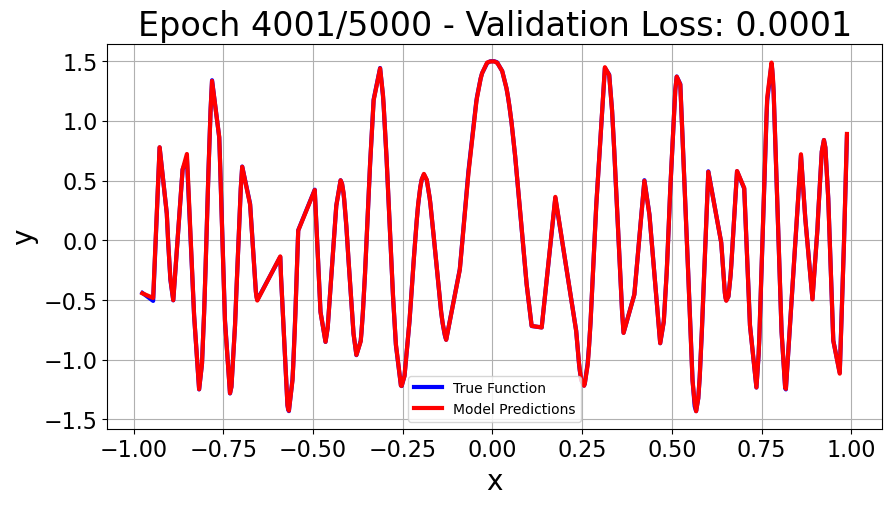

Epoch 4001/5000, Training Loss: 0.0000, Validation Loss: 0.0001


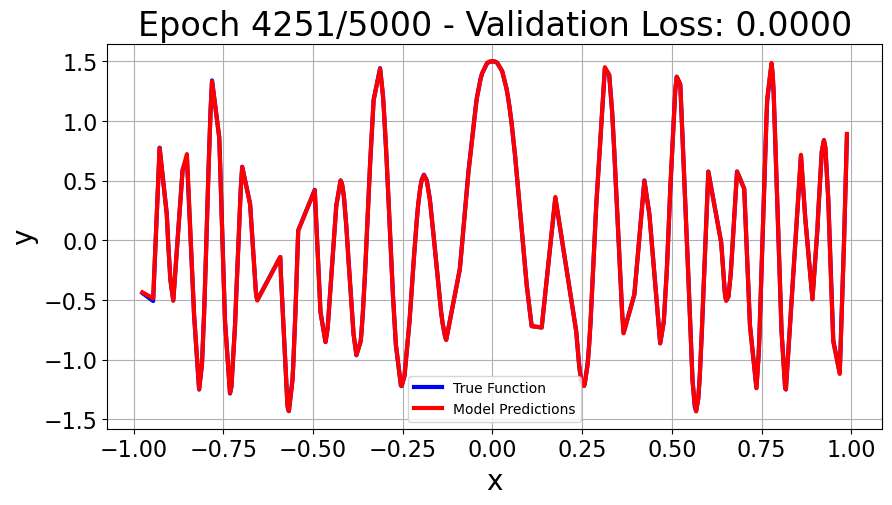

Epoch 4251/5000, Training Loss: 0.0000, Validation Loss: 0.0000


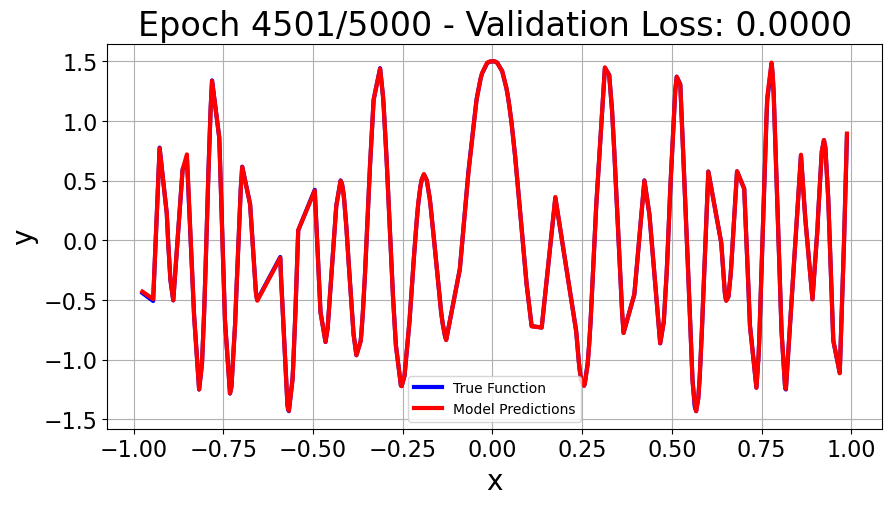

Epoch 4501/5000, Training Loss: 0.0000, Validation Loss: 0.0000


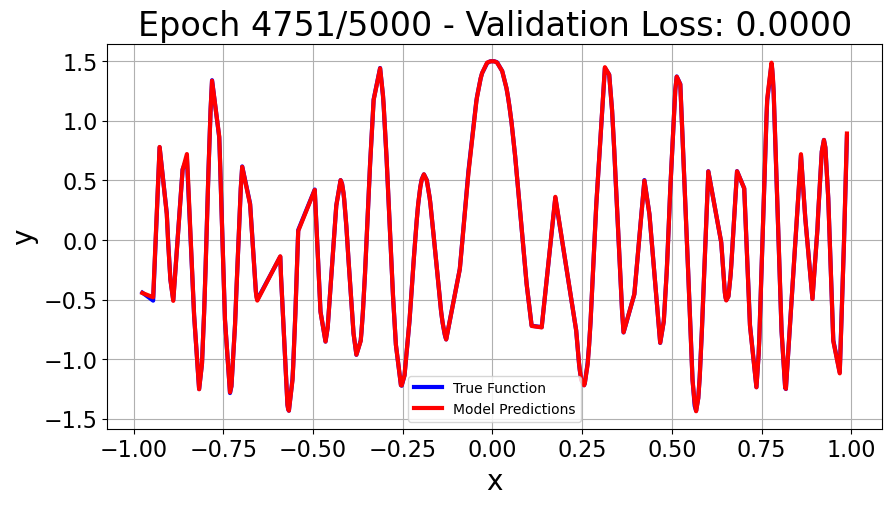

Epoch 4751/5000, Training Loss: 0.0000, Validation Loss: 0.0000


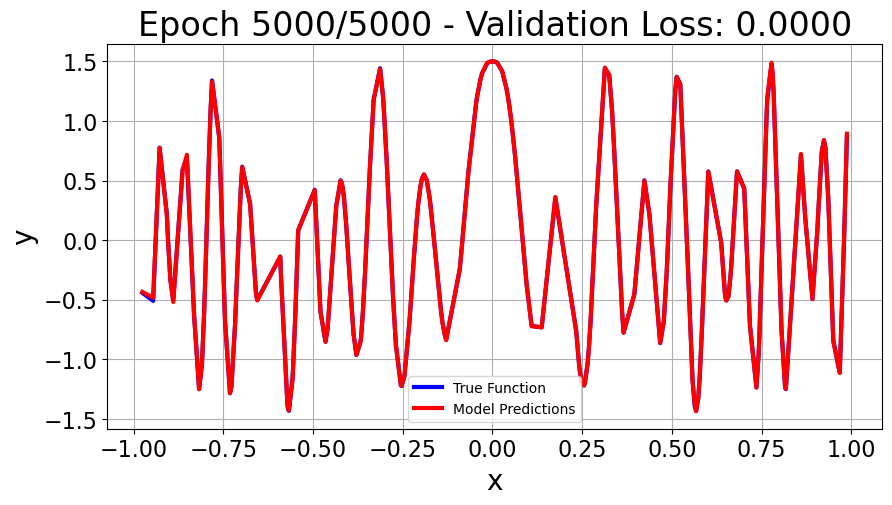

Epoch 5000/5000, Training Loss: 0.0000, Validation Loss: 0.0000


In [29]:
# Initialize trainer
trainer = TrainJaxModel(
    model=model,
    input_data=jnp.array(x, dtype=jnp.float32),
    target_data=jnp.array(y_data, dtype=jnp.float32),
    optimizer='adam',
    loss_fn='mse',
    learning_rate=scheduler,
    num_epochs=5000,
    batch_size=300,
    random_seed=42
)
# Run training
trained_model, losses = trainer.training_loop(print_every=250)